In [246]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [247]:
# declaring image path
img_path_1 = "/content/drive/MyDrive/Filters_colorectal/bilateral/08_EMPTY/image101.png"
img_path_2 = "/content/drive/MyDrive/Filters_colorectal/bilateral/08_EMPTY/image102.png"

In [248]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [249]:
img_1 = cv2.imread(img_path_1)
img_2 = cv2.imread(img_path_2)

print("Image_1 shape: ", img_1.shape)
print("Image_2 shape: ", img_2.shape)

Image_1 shape:  (150, 150, 3)
Image_2 shape:  (150, 150, 3)


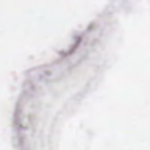

In [250]:
# first image
cv2_imshow(img_1)

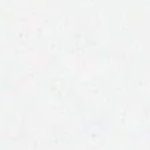

In [251]:
# isecond image
cv2_imshow(img_2)

In [252]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import numpy as np

In [253]:
# defining transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                        ])

In [254]:
from PIL import Image

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [255]:
# demo
# img_tensor_1 = data_transforms(img_1)

In [256]:
# function to convert image into tensor
def img_to_tensor(image_path):
  pil_img = Image.open(image_path)
  transformed_img = data_transforms(pil_img)
  transformed_img = transformed_img.reshape(1, 3, 224, 224)
  return transformed_img

In [257]:
# converting image into tensor
# pytorch data transform accepts PIL image

img_tensor_1 = img_to_tensor(img_path_1)
img_tensor_2 = img_to_tensor(img_path_2)

print(f"shape after converting into tensor for first image: {img_tensor_1.shape}")
print(f"shape after converting into tensor for second image: {img_tensor_2.shape}")

shape after converting into tensor for first image: torch.Size([1, 3, 224, 224])
shape after converting into tensor for second image: torch.Size([1, 3, 224, 224])


In [258]:
# Now we need to take VGG-16 pre-trained model
vgg_16 = models.vgg16(weights='IMAGENET1K_V1')  #pretrained=True

In [259]:
# change the number of classes
# vgg_16.classifier[0] = nn.Linear(8192, 4096) # demo
vgg_16.classifier[2] = nn.Dropout(p= 0.5, inplace= False)
vgg_16.classifier[3] = nn.Linear(4096, 1024)
vgg_16.classifier[5] = nn.Dropout(p= 0.25, inplace= False)
vgg_16.classifier[6] = nn.Linear(1024, 8)

In [260]:
# to determine the last conv. layer
print(vgg_16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [261]:
# define model path
model_path= "/content/drive/MyDrive/Filters_colorectal/vgg_16_cam.pt"

# loading pre-trained weights
vgg_16.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [262]:
# defining custom model

class VGG_16_GCAM(nn.Module):
    def __init__(self):
        super(VGG_16_GCAM, self).__init__()

        # get the pretrained VGG-16 network
        self.vgg = vgg_16

        # taking feature maps upto last layer before the maxpooling, which layer 29
        self.features_conv = self.vgg.features[:30]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the model
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None


    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)
        # print(x.shape)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        # print(x.shape)
        x = x.view((1, -1))
        # print(x.shape)
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features_conv(x)


In [263]:
# initialize the custom grad-cam model
gcam_model = VGG_16_GCAM()

In [264]:
# you need to train the model here

In [265]:
# evaluation mode
gcam_model.eval()

VGG_16_GCAM(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [266]:
# getting prediction
img_1_pred = gcam_model(img_tensor_1)

In [267]:
img_1_pred

tensor([[-2.1208e+01, -2.1816e+01, -2.4585e+01, -3.1475e+01, -2.0631e+01,
         -3.9754e+01, -7.4834e-03,  1.5056e+01]], grad_fn=<AddmmBackward0>)

In [268]:
# gradient is available at from the prediction, see the previous cell
img_2_pred = gcam_model(img_tensor_2)

In [269]:
# getting predicted index
img_1_index = img_1_pred.argmax(dim=1)
img_2_index = img_2_pred.argmax(dim=1)

print(f"Predicted index: {img_1_index}")
print(f"Predicted index: {img_2_index}")

Predicted index: tensor([7])
Predicted index: tensor([7])


In [270]:
# getting index value as an item
ind_val_1 = img_1_index.item()

# perform backpropagation
img_1_pred[:,ind_val_1].backward()

# pull the gradients out of the model
gradients = gcam_model.get_activations_gradient()
print(gradients)

tensor([[[[-0.0199,  0.0000, -0.0062,  ...,  0.0030,  0.0000, -0.0023],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0358,  0.0000, -0.0215,  ...,  0.0000, -0.0071,  0.0000],
          ...,
          [ 0.0000,  0.0000, -0.0176,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0220,  0.0000, -0.0246,  ...,  0.0000, -0.0213,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0007,  0.0000,  0.0072,  ...,  0.0000,  0.0310,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [-0.0050,  0.0000,  0.0001,  ...,  0.0000, -0.0079,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0115,  0.0000,  0.0065,  ...,  0.0000, -0.0097,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0062,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

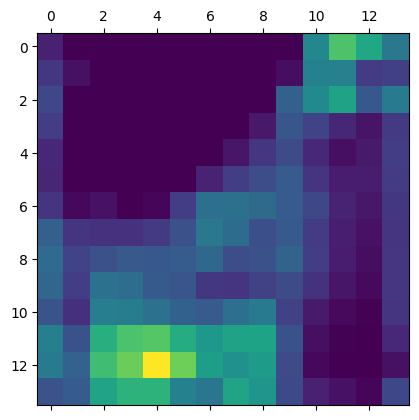

In [271]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = gcam_model.get_activations(img_tensor_1).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())
plt.show()

In [272]:
heatmap.squeeze().shape

torch.Size([14, 14])

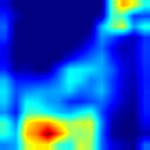

In [273]:
# resizing the heatmap and applying colormap
heatmap = heatmap.numpy()
heatmap = cv2.resize(heatmap, (img_1.shape[0], img_1.shape[1]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
cv2_imshow(heatmap)

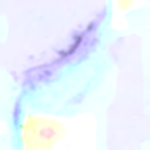

In [274]:
# grad-cam image
superimposed_img = heatmap * 0.35 + img_1
cv2_imshow(superimposed_img)

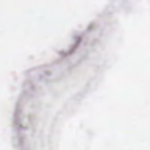

In [275]:
# original image
cv2_imshow(img_1)

In [276]:
# function to get grad cam image

def get_gradcam(input_img_path, fe_model):
  img = img_to_tensor(input_img_path)   # take image path as input

  pred_img = fe_model(img)
  index = pred_img.argmax(dim=1)
  ind_val = index.item()
  pred_img[:,ind_val].backward()

  # pull the gradients out of the model
  gradients = fe_model.get_activations_gradient()

  # pool the gradients across the channels
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  # get the activations of the last convolutional layer
  activations = fe_model.get_activations(img).detach()

  # weight the channels by corresponding gradients
  for i in range(512):
      activations[:, i, :, :] *= pooled_gradients[i]

  # average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()

  # relu on top of the heatmap
  heatmap = np.maximum(heatmap, 0)

  # normalize the heatmap
  heatmap /= torch.max(heatmap)
  img_2 = cv2.imread(input_img_path)

  heatmap = heatmap.numpy()
  heatmap = cv2.resize(heatmap, (img_2.shape[1], img_2.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap * 0.35 + img_2

  return img_2, superimposed_img


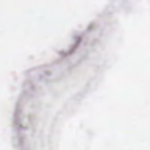

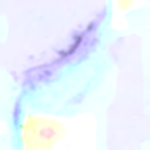

In [277]:
# now calling the function to get grad-cam image alongwith  original image
org_img_1, gcam_img_1 = get_gradcam(img_path_1, gcam_model)
cv2_imshow(org_img_1)
print()
cv2_imshow(gcam_img_1)

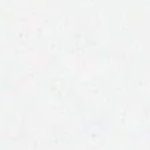

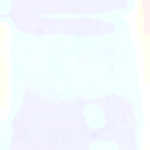

In [278]:
org_img_2, gcam_img_2 = get_gradcam(img_path_2, gcam_model)
cv2_imshow(org_img_2)
print()
cv2_imshow(gcam_img_2)

In [280]:
quality_params = [cv2.IMWRITE_PNG_COMPRESSION, 0]

# Save the image with high resolution and quality
cv2.imwrite('101_EMPTY.png', gcam_img_1, quality_params)

True